# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'C:\\Users\\HP\\Documents\\GitHub\\02_segbot\\ae353_segbot.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_segbot.Simulator(
    display=True,
    width=480,
    height=320,
    bumpy=True,
)

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [3]:
class Controller:
    def __init__(self, K, e_le, e_he, ve, we, v2e, thetae):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.ve = ve
        self.we = we
        self.v2e = v2e
        self.thetae = thetae
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # FIXME: replace the following lines
        x = np.array([lateral_error - self.e_le, heading_error - self.e_he, forward_speed - self.ve, turning_rate - self.we, pitch_rate - self.v2e, pitch_angle - self.thetae])
        u = -self.K@x
        tau_R = u[0]
        tau_L = u[1]
        right_wheel_torque = tau_R
        left_wheel_torque = tau_L
        
        return right_wheel_torque, left_wheel_torque

Create an instance of the controller.

In [4]:
e_le= 0.0
e_he = 0.0
ve = 3.8
thetae = 0.
we = 0.
v2e = 0.
tau_Re = 0.
tau_Le = 0.

K = np.array([[8.705159665502574, 27.021985997019915, -0.23603927024932259, 6.427898112684182, -0.17552727121803446, -5.712966264137405], [-8.700840606513488, -27.01241173620554, -0.03431680860448798, -6.426680471293729, -0.09195660109379074, -5.449516273646485]])
controller = Controller(K, e_le, e_he, ve, we, v2e, thetae)

Reset the simulator with given initial conditions. You may also change the angular velocity of the station if you like, but - beware! - doing so will change the amount of artificial gravity.

In [5]:
simulator.reset(
    initial_speed=0.9,
    initial_lateral_error=-0.1,
    initial_heading_error=0,
    initial_pitch=-0.,
    station_velocity= -0.2,
)

Reset the controller.

In [6]:
controller.reset()

Choose a camera view from the following options:
* `camera_sideview()`
* `camera_backview()`
* `camera_wideview()`

In [39]:
simulator.camera_backview()

Run the simulator.

In [7]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=20.,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Get, show, and save a snapshot of the simulation after the last time step.

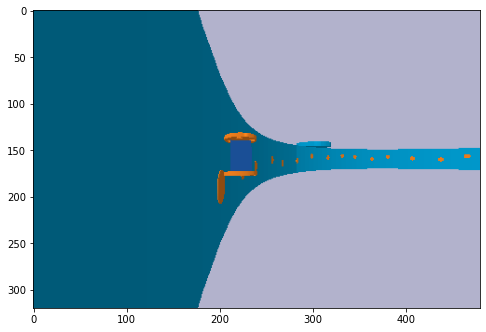

In [9]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

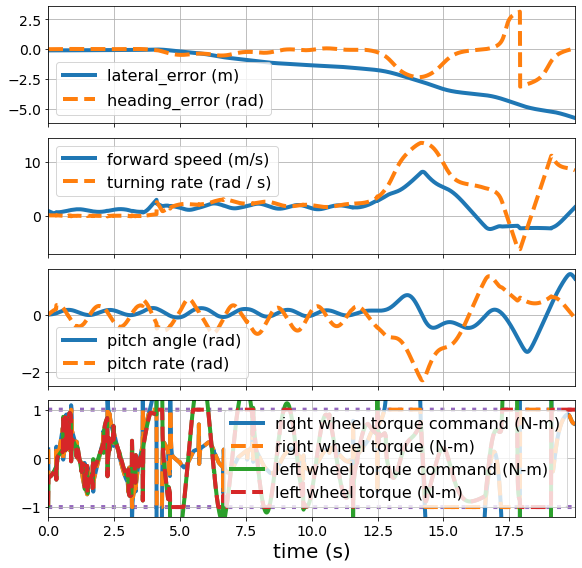

In [49]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [11]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)